This document shows how to use this `nevis`-based optimiser benchmarking framework.

## Defining a new algorithm

Some examples can be found in the `./algorithm` directory. Take Dual Annealing (`./algorithm/dual_annealing.py`) as an example.

We define a function with following signature, decorated by `@optimizer`:

```python
def run_dual_annealing(
    f, 
    x_max, 
    y_max, 
    rand_seed, 
    init_guess, 
    trial: optuna.Trial,
    get_budget,
    mark_end_of_iteration,
):
```

where 
- `f` is a function that takes a tuple of coordinates in metres and returns its **negative** height (and thus should be minimised). Optionally, you can pass a `grad` argument to `f`, which should be an `numpy` array of size `2` and is modified in place to be the gradient of the function at the given coordinate (as one would do in `nlopt`);
- `x_max` and `y_max` define the boundary of the problem, which is `[0, x_max] × [0, y_max]`;
- `rand_seed` defines the random seed for the run. It should be used in places like `np.random.seed(rand_seed)` or passed to the optimiser if applicable (such as in this case the `seed` argument of `scipy.optimize.dual_annealing`);
- `init_guess` defines the initial guess for the run. It should be passed to the optimiser (such as in this case the `x0` argument of `scipy.optimize.dual_annealing`);
- `trial` is an instance of `optuna.Trial` and is used for defining hyper-parameters. See [here](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html) for more;
- `get_budget` is a function that takes no arguments and returns the remaining number of function evaluations for the current run;
- `mark_end_of_iteration` is a function that should be called at the end of each 'iteration' (if it applies to the algorithm in question). This is used in making animations.

The function `run_dual_annealing` should return a dictionary of the following form:

```python
{
    'x': (x_best, y_best), # coordinates of the minimum returned by the optimiser
    'z': z_best, # minimum returned by the optimiser
    'message': 'A message of why the run terminated', # optional
    'trajectory': [(x, y), ...], # optional
}
```

The decorator `@optimiser` records every function call to `f` and ensures that as our optimiser calls `f`, the number returned by `get_budget` reduces accordingly. The decorated function returns a `Result` object that contains all information related to the run and its result.

Then we define an algorithm instance using the function `run_dual_annealing`:

```python
dual_annealing = Algorithm(
    name='Dual Annealing',
    func=run_dual_annealing,
    version=3
)
```

where `name` is the name of the algorithm and `version` is an integer. It is intended that you change the `version` number when you modify the body of `func` (i.e. when you change how the algorithm works), so that results are recorded separately for different versions of the algorithm.

## Defining some constants
Check `config.py` for constants defined in the framework. It is assumed that these values are unchanged throughout the usage; otherwise, data stored would be inconsistent.

## `Result` class explained

Each time an algorithm instance is run, we get a `Result` object. This object records the following data:

```
'algorithm_name'
'algorithm_version'
'instance_index'
'result_index'

'info' # a dict that contains above four keys

'ret_point' # returned point (x, y) tuple of floats
'ret_height' # height returned by the optimiser as-is, float
'max_height' # 'returned height' as defined in the paper, i.e. the maximum height obtained before the termination criteria are met
'message' # string

'points' # a list of all the evaluated points during this run
```

Based on the list of `points`, the following data is calculated:

```
'is_success' # bool
'eval_num' # number of function evaluations 
'gary_score' # gary score obtained
'len_points' # length of returned points
```

Basically, we try to find the point with the maximum height in the first `MAX_FES` evluations of `points`. If there is one such evaluation that is higher than `SUCCESS_HEIGHT`, then this run is successful and `eval_num` is the index of the first such evaluation. If all considered evaluations are not higher than `SUCCESS_HEIGHT` then the highest one is picked for calculating the `gary_score` for this run. These three values are used for calculating the performance measures of an algorithm instance. 

`len_points` is simply the length of the `points` list: this is not used in calculating performance measures of an algorithm instance; in fact, it can sometimes exceed `MAX_FES` as some algorithms do not obey this termination criteria strictly. `len_points` is recorded mainly to identify if a run was terminated early on its own (like what local optimisers do).

Note that the height `max_height` we use to determine `is_success` and `gary_score` is restricted to the first `MAX_FES` ones in `points`. It is theoretically possible that `max_height` is not the same as `ret_height`, which is the height returned by the optimiser as-is, if the optimiser does not obey `MAX_FES` strictly and `ret_height` is discovered after `MAX_FES` evaluations. 

## How the data is saved

`optuna`, our hyper-parameter tuning framework, saves the data for each algorithm instance that is generated, including the hyper-parameter used and the performance measure (GERT).

On the other hand, the data regarding each run of any given algorithm instance is saved using the `SaveHandler` class. This can be either a `SaveHandlerMongo` (using `MongoDB`) or a `SaveHandlerJSON` (using `JSON` files under a given directory). 

When we save a run result, the following data is always saved:
```
'algorithm_name'
'algorithm_version'
'instance_index'
'result_index'
'info' 
'ret_point' 
'ret_height' 
'message' 
'is_success' 
'eval_num'
'len_points'
'gary_score' 

```

In addition, a run can be saved with `points`. In this case this run is saved in 'full'; otherwise, it is 'partially' saved. In theory, since the random seed and initial guess are determined by `result_index`, even if we only save the result partially, we could recover the evaluated points just by running it again.



## An actual example

Let's use the predefined Dual Annealing as an actual example. 

In [8]:
from algorithms import dual_annealing
from framework import *
import os

# make directories if they do not exist
if not os.path.exists('../result'):
    os.makedirs('../result')

if not os.path.exists('../result/json'):
    os.makedirs('../result/json')

# define a save handler
save_handler = SaveHandlerJSON('../result/json', 'test')
dual_annealing.tune_params(
    db_path='../result/4.db',
    iter_num=10, # just for test purposes, only 10 instances are generated
    save_handler=save_handler,
    # plot_path='../result/', # if we want a plot for every instance generated
)

[I 2024-08-31 23:11:32,212] A new study created in RDB with name: Dual Annealing-3
1007704it [01:57, 8547.56it/s]                             
[I 2024-08-31 23:13:35,904] Trial 0 finished with value: 15995.301587301587 and parameters: {'initial_temp': 5230.0, 'restart_temp_ratio': 2e-05, 'visit': 2.62, 'accept': -5.0}. Best is trial 0 with value: 15995.301587301587.
100%|██████████| 1000000/1000000 [02:05<00:00, 7967.21it/s]
[I 2024-08-31 23:15:47,667] Trial 1 finished with value: 200000.0 and parameters: {'initial_temp': 21092.416993216346, 'restart_temp_ratio': 2.380263597238422e-06, 'visit': 2.1763134993265165, 'accept': -2.146217011440433}. Best is trial 0 with value: 15995.301587301587.
1028597it [01:56, 8841.81it/s]                             
[I 2024-08-31 23:17:50,902] Trial 2 finished with value: 42858.208333333336 and parameters: {'initial_temp': 0.23288797155559268, 'restart_temp_ratio': 0.02066530444482545, 'visit': 2.6378949670139766, 'accept': -3.89422441455559}. Best is

During this tuning process we can use [optuna dashboard](https://optuna-dashboard.readthedocs.io/en/latest/getting-started.html) to see the performance of each instance (or trial, in the `optuna` context), by running 

```
optuna-dashboard sqlite:///../result/4.db
```

and then open `http://127.0.0.1:8080/` with your browser to see the charts and data.

<!-- As you can see we have plotted the performance figures for all instances generated. We might want to disable this by passing `make_all_plots=False` to `tune_params`. -->

Now we can check the best instance selected from this hyper-parameter tuning process:

In [9]:
ins = dual_annealing.best_instance
ins.trial.params

{'initial_temp': 5230.0,
 'restart_temp_ratio': 2e-05,
 'visit': 2.62,
 'accept': -5.0}

By default this instance hasn't been loaded with results, so we need to reload the results from the save handler:

In [10]:
ins.results

[]

In [11]:
ins.load_results(save_handler=save_handler)

In [12]:
ins.results

[{'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 1, 'result_index': 0, 'ret_point': [297124.99764372245, 773325.0008833031], 'ret_height': 1119.699509395941, 'message': 'Maximum number of function call reached during dual annealing', 'is_success': False, 'eval_num': 50000, 'len_points': 50024, 'gary_score': 0, 'info': {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 1, 'result_index': 0}},
 {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 1, 'result_index': 1, 'ret_point': [298875.00061828946, 798924.9999983204], 'ret_height': 1309.0999729857326, 'message': 'Maximum number of function call reached during dual annealing', 'is_success': False, 'eval_num': 50000, 'len_points': 50028, 'gary_score': 3, 'info': {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 1, 'result_index': 1}},
 {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 1, 'result_

In [13]:
ins.performance_measures() 

{'success_rate': 0.13636363636363635,
 'failure_rate': 0.8636363636363636,
 'success_cnt': 3,
 'avg_success_eval': 19234.666666666668,
 'hv': 4195.272727272727,
 'par2': 88986.54545454546,
 'par10': 434441.0909090909,
 'avg_height': 1265.0262501973134,
 'ert': 335901.3333333334,
 'sp': 141054.22222222225,
 'success_rate_upper': 0.3333541187947,
 'success_rate_lower': 0.04748917264236269,
 'success_rate_length': 0.2858649461523373,
 'gary_ert': 15995.301587301587}

Now `ins` is only partially loaded because it was partially saved in the hyper-parameter tuning. We won't be able to make a plot directly:

In [14]:
ins.plot_convergence_graph()

AssertionError: Results must be fully loaded.

To handle this, we simply rerun this instance. 

In [15]:
ins.run(
    save_handler=save_handler,
    restart=True, # we want to rerun everything, not starting from what we have saved now
    save_partial=False, # we do not want to save partial results
)

1007704it [01:57, 8561.62it/s]                             


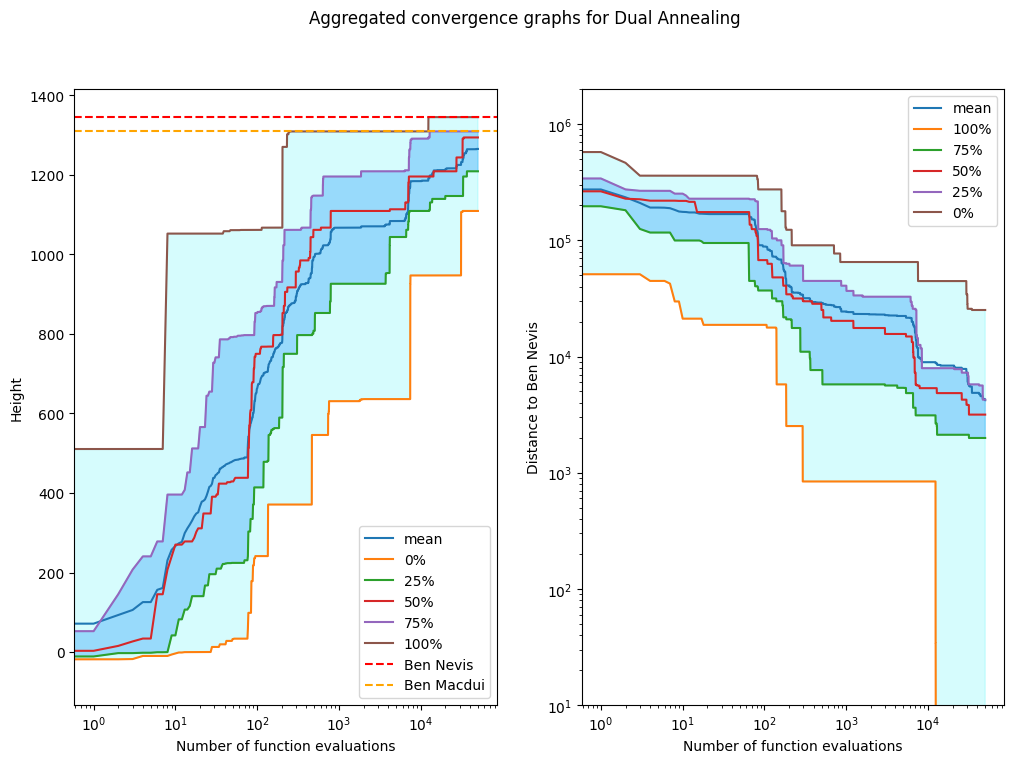

In [16]:
ins.plot_convergence_graph()

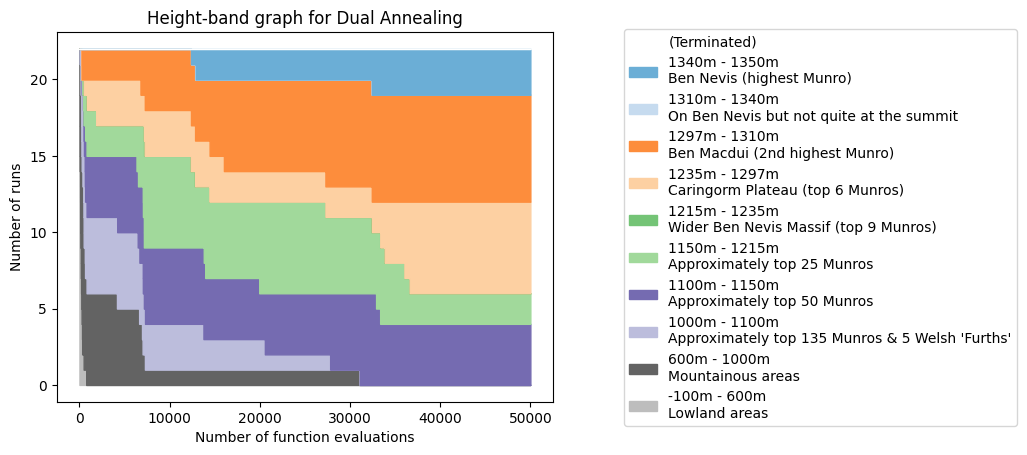

In [17]:
ins.plot_stacked_graph()

In plotting this stakced graph, we could select if we want the last value to be duplicated (default) or not:

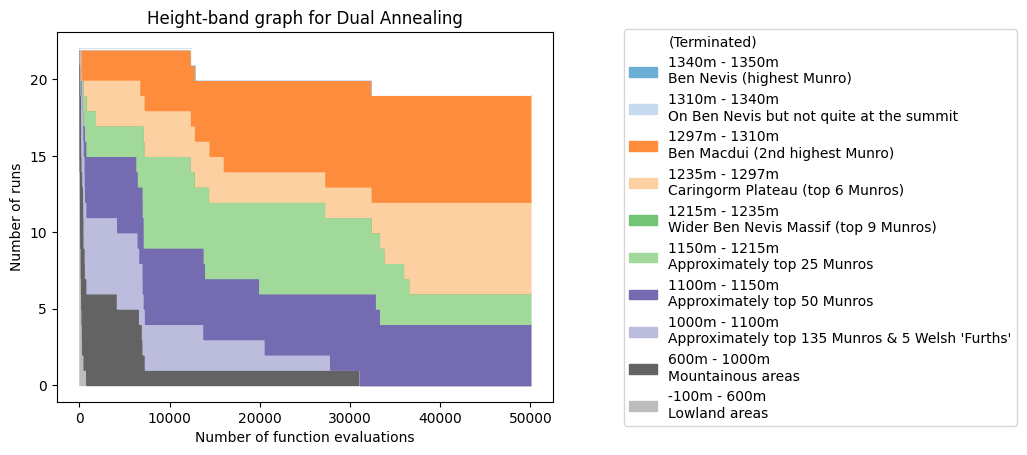

In [18]:
ins.plot_stacked_graph(mode='terminate')

We can also produce an animation for the 0-th run of this instance:

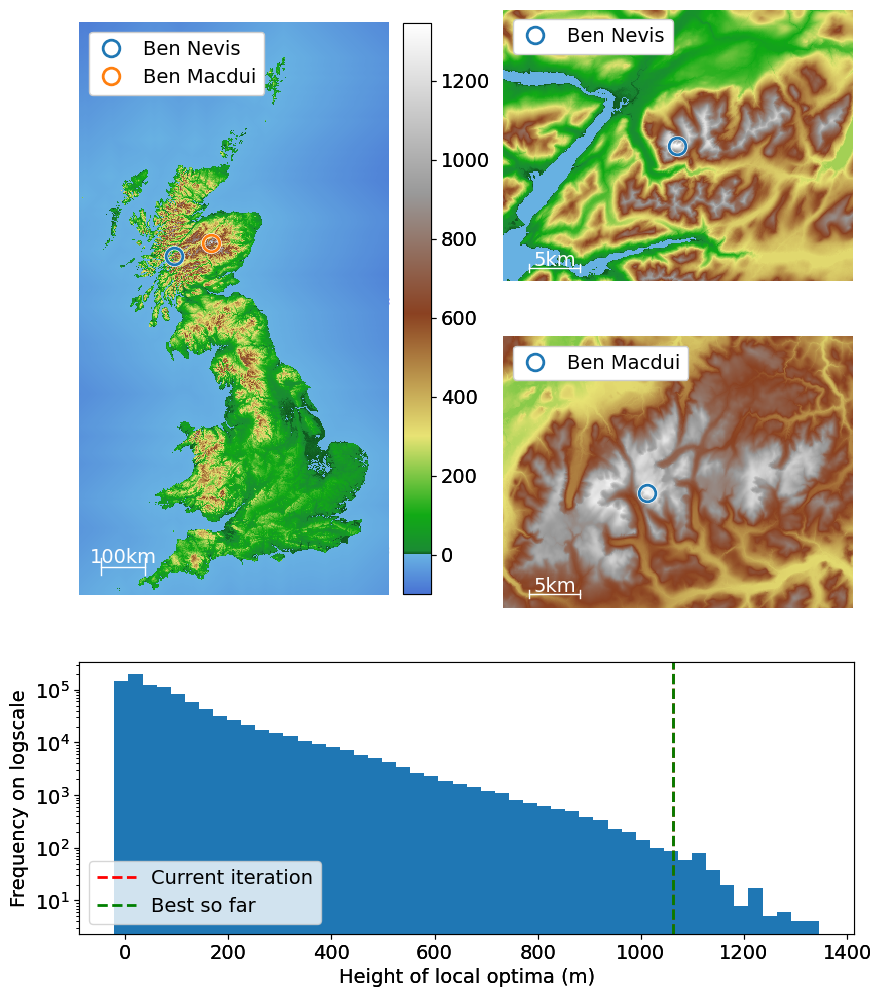

In [23]:
import numpy as np
# the basin-problem scripts should be run beforehand
maxima_heights = np.load('../basin-problem/res/maxima_heights.npy')
anim = ResultAnimation(ins.results[0], 
                       maxima_heights, 
                       mode='evaluations', # A frame depicts a evaluation. 
                       # Another mode is 'iterations', where a frame depicts an iteration,
                       # which would rely on 'mark_end_of_iteration' for the sepration of
                       # iterations.
                       frame_num=200
                       # We only render 200 frames for demonstration. It can be slow when
                       # the frame number is large.
                       )
anim.save('../result/DA-test.mp4', fps=5)

## How to run hyper-parameter tuning concurrently

Please refer to [optuna documentation](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html) for details.

An example is like this: create a Python script that calls the `tune-params` (we call it `run.py`):

```python
from algorithms import dual_annealing
from framework import SaveHandlerJSON

save_handler = SaveHandlerJSON('../result/json/')
algo = dual_annealing
algo.tune_params(
    db_path='../result/main.db',
    save_handler=save_handler,
    iter_num=40,
)
```

where `iter_num` should be set to the nubmer of algorithm instances generated by each process. Note that there should be no need to create a new study manually (i.e. use the `optuna create-study` command as said in the tutorial), because `tune_params` will create a new study if there isn't one and load the exsiting study if it finds the same study in the SQLite database at `db_path` (identified by the name and version of the current algorithm).

Now you can run this `run.py` in the terminal. You might start multiple terminals and run the script in each of them; or you can write a shell script that helps you with this. An example would be like this:

```bash
#!/usr/bin/env bash

source ../venv/bin/activate
for ((i = 1; i <= 5; i++)); do
  echo "Running iteration $i"
  python3 run.py &
done

wait $(jobs -p)
echo "All iterations finished!"
```

Clearly you should change the number of concurrent processes in the `for` loop above. In our case there will be 5 concurrent processes and each of them will generate 50 algorithm instances. They will share the study database at '../result/main.db', and as such, any iteration of any process will be able to utilise the data of all previous runs (carried out by all processes) and thus based on the study algorithm picks a new set of hyper-parameters to generate a new algorithm instance accordingly. 

## Handling an early-terminating algorithm

There are two options for handling an early-terminating algorithm.

Option 1. Implement it as its multi-start version. This option is used for all early-terminating algorithms in this repo, including CMA-ES, Differential Evolution, Nelder-Mead and PSO. The pattern is as follows (taking CMA-ES as example): 

```python

@optimizer
def run_cmaes(
    f,
    x_max,
    y_max,
    rand_seed,
    init_guess,
    trial: optuna.Trial,
    get_budget,
    mark_end_of_iteration,
):
    # ... some initialisation
    x, z = None, float('inf')
    i = 0

    # carry out iterations until the budget for
    # function evaluations is exhausted
    while get_budget() > 0 and z > -SUCCESS_HEIGHT:
        opt = pints.OptimisationController(
            # ... other params
            x0=b.sample() if i > 0 else init_guess, 
            # the initial guess is init_guess for the 0-th iteration,
            # and is generated using numpy random methods (or, in this case, the PINTS sampling method) for subsequent iterations.
        )
        # optimise for this iteration
        x1, z1 = opt.run()
        # update our result x, z
        if z1 < z:
            x, z = x1, z1
        i += 1
        mark_end_of_iteration()
    
    return {
        'x': x,
        'z': z,
    }
```

Then multi-start version of this algorithm will always either reach `MAX_FES` function evals or discover Ben Nevis.

Option 2. You may leave the early-terminating algorithm as-is, but when calculating the performance or plotting diagrams for its instance, you set the `using_restart_results` param to `True`. In this way, the results will be automatically combined to be 'restart results', i.e. the results that would have been produced if the algorithm were implemented as its multi-start version, and then the performance measures or plots are based on these 'restart results'. This `using_restart_results` param is supported by the following methods of the `AlgorithmInstance` class:

- `performance_measures`,
- `plot_convergence_graph`,
- `plot_stacked_graph`,
- `performance_to_latex`.

You may also want to set the `cache_enabled` property of the instance to `True` so that the restart results are cached, supposing you have finished running all the results for this instance.

Note that if the last restart result (obtained from combining early-terminating results) is not long enough to either be successful or reach `MAX_FES` function evals, then it will be discarded.